In [5]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from parse import *
from config import api_key
import nasdaqdatalink
import scipy.stats as stats
from statistics import mean

In [32]:
# Load key for Nasdaq API
nasdaqdatalink.ApiConfig.api_key = api_key

# Load .csv with 'Forbes 100 preferered employer ranking'; 'Glassdoor score'; 'Nasdaq/Mergent' codes
forbes_source = pd.read_csv("resources/employers_clean.csv")

# Format .csv file
forbes_source_clean = forbes_source.dropna(subset=['mergent_ticker']).astype({'mergent_compnumber' : 'int64'})

# Parameters for Nasdaq query: list of insustrial sectors; financial metrics
mic_extract = forbes_source_clean['mergent_mic'].unique()
forbes_mics_forquery = list(mic_extract)
mapcode = [
    '-5011', # Return on Equity: (Net Income / Average Stockholders' Equity Over Period) * 100
    '-4023'] # EPS – Net Income – Diluted

# Run API 
forbes_df = nasdaqdatalink.get_table('MER/F1', mic=forbes_mics_forquery, mapcode=mapcode, reportdate='2021-12-31', reporttype='A')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 99
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RANK                87 non-null     int64  
 1   NAME                87 non-null     object 
 2   TICKER              87 non-null     object 
 3   INDUSTRIES          87 non-null     object 
 4   Country             87 non-null     object 
 5   EMPLOYEES           87 non-null     object 
 6   Glassdoor Rating    87 non-null     float64
 7   City                87 non-null     object 
 8   mergent_name        87 non-null     object 
 9   mergent_ticker      87 non-null     object 
 10  mergent_compnumber  87 non-null     int64  
 11  mergent_mic         87 non-null     object 
dtypes: float64(1), int64(2), object(9)
memory usage: 8.8+ KB


In [24]:
# Prepare empty lists for Nasdaq industry data
compnumber_list = []
ticker_list = []
currency_list = []
mic_list = []
roe_list = []
eps_list = []

# Build Nasdaq industry data
for index, row in forbes_df.iterrows():
    if forbes_df.loc[index, 'mapcode'] == -5011:
        cn = forbes_df.loc[index, 'compnumber']
        tk = forbes_df.loc[index, 'ticker']
        cl = forbes_df.loc[index, 'currency']
        mc = forbes_df.loc[index, 'mic']
        rt = forbes_df.loc[index, 'amount']
        compnumber_list.append(cn)
        ticker_list.append(tk)
        currency_list.append(cl)
        mic_list.append(mc)
        roe_list.append(rt)

industry_data_build = {
    'comp_number' : compnumber_list, 
    'ticker' : ticker_list,
    'currency' : currency_list,
    'sector' : mic_list,
    'ROE' : roe_list}

industry_data_raw = pd.DataFrame(industry_data_build)
industry_data_df = industry_data_raw.loc[(industry_data_raw["ROE"]>-500) & (industry_data_raw["ROE"]<500)]


In [33]:
# Create column for industrial sectors summarised one level up in Forbes ranking
forbes_mics_shortlist = []
sector_col = []
for index, row in forbes_source_clean.iterrows():
    sector_col = forbes_source_clean.loc[index, 'mergent_mic']
    x = sector_col.split(".")
    forbes_mics_shortlist.append(f"{x[0]}.{x[1]}")
forbes_source_clean["sector_short"]= list(forbes_mics_shortlist)


In [36]:
# Create column for industrial sectors summarised one level up in Industy Data df
sector_mics_shortlist =[]
for index, row in industry_data_df.iterrows():
    mic = industry_data_df.loc[index, 'sector']
    sector_mics_shortlist.append(f"{mic.split('.')[0]}.{mic.split('.')[1]}")
industry_data_df["sector_short"]= list(sector_mics_shortlist)

selected_mic = list(set(forbes_source_clean["sector_short"]))


/Users/javiergausachs/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
# Add ROE column to ranked_cos df
stripped_sectors_roes = industry_data_df.loc[:, ["comp_number", "ROE"]]
sectors_ranked_wroes = forbes_source_clean.merge(stripped_sectors_roes, left_on=str("mergent_compnumber"), right_on=str("comp_number"))

sectors_ranked_wroes_stat = sectors_ranked_wroes.groupby(["sector_short"]).mean()

sector_ranked_41 = sectors_ranked_wroes.loc[sectors_ranked_wroes["sector_short"]=="4.1"]


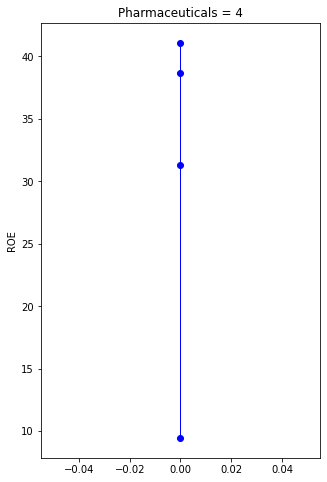

The lower quartile of ROE is: 25.839274000000003
The upper quartile of ROE is: 39.27313625
The interquartile range of ROE is: 13.433862249999997
The the median of ROE is: 34.983253 
Values below 5.6884806250000075 could be outliers.
Values above 59.423929625 could be outliers.


In [54]:
plot_selected_mic = sector_ranked_41["ROE"]

plot_xs = list(plot_selected_mic)
plot_ys = [0] * len(plot_selected_mic)

fig1, ax1 = plt.subplots(figsize=(5,8))
ax1.set_title(f"Pharmaceuticals = {len(plot_xs)}")
ax1.set_ylabel('ROE')
ax1.plot(plot_ys, plot_xs, marker="o", color="blue", linewidth=1)
plt.show()

# Quartiles calculation
quartiles = plot_selected_mic.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of ROE is: {lowerq}")
print(f"The upper quartile of ROE is: {upperq}")
print(f"The interquartile range of ROE is: {iqr}")
print(f"The the median of ROE is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

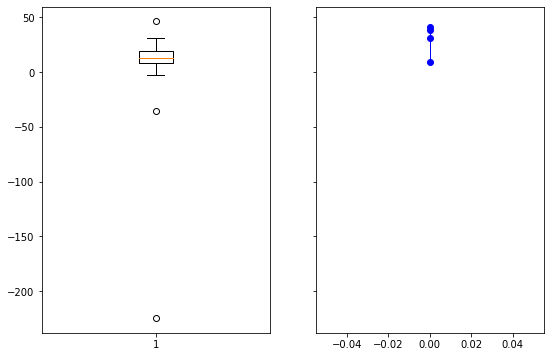

The lower quartile of ROE is: 7.895579
The upper quartile of ROE is: 19.048945
The interquartile range of ROE is: 11.153366
The the median of ROE is: 13.039099 
Values below -8.834470000000001 could be outliers.
Values above 35.778994 could be outliers.


In [56]:
mic_names = pd.read_csv("resources/mergent_mic-codes.csv").drop(columns="MIC").dropna()

# Plot of ROE for sector [0]
selected = selected_mic[5]
selected_name = mic_names.loc[mic_names["Code"]==float(selected)]
selected_name_l = list(selected_name["Description"])

plot_pre_x = industry_data_df.loc[industry_data_df["sector_short"]==selected, "ROE"]
plot_x = list(plot_pre_x)
plot_y = [0] * len(plot_x)

fig1, axs = plt.subplots(1,2, figsize=(9, 6), sharey=True)
axs[0].boxplot(plot_x)
axs[1].plot(plot_ys, plot_xs, marker="o", color="blue", linewidth=1)
plt.show()

# Quartiles calculation
quartiles = plot_pre_x.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of ROE is: {lowerq}")
print(f"The upper quartile of ROE is: {upperq}")
print(f"The interquartile range of ROE is: {iqr}")
print(f"The the median of ROE is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")


In [58]:
stats.ttest_1samp(plot_xs, mean(plot_x))

Ttest_1sampResult(statistic=3.5411438074270634, pvalue=0.038332355292852664)

<AxesSubplot:title={'center':'ROE'}, xlabel='sector_short'>

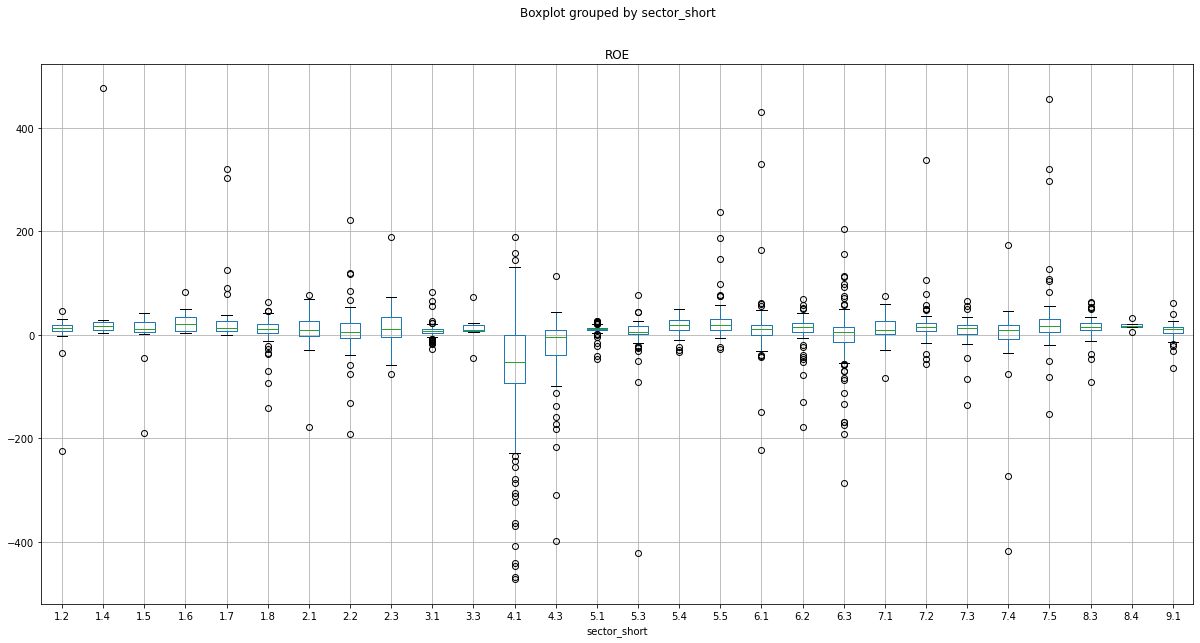

In [59]:
industry_data_df.boxplot("ROE", by="sector_short", figsize=(20, 10))